In [1]:
%who

Interactive namespace is empty.


In [52]:
import xarray as xr
import numpy as np
import geopandas as gpd
import datetime
import matplotlib
import pandas as pd
import seaborn as sns


In [2]:
def calc_areaAvg(da, latName = 'lat', lonName = 'lon'): 
    weights = np.cos(np.deg2rad(da[latName]))
    weights.name = "weights"
    da_weighted = da.weighted(weights)
    weighted_mean = da_weighted.mean([latName, lonName])
    return weighted_mean

def calc_regAvg_monAnom_masked(da_monAnom, da_monRef, da_mask):
    da_anom_regAvg = calc_areaAvg(da_monAnom*da_mask)
    da_ref_regAvg = calc_areaAvg(da_monRef*da_mask)
    da_ref_regAvg_forPerc = da_ref_regAvg.sel(month = da_anom_regAvg['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_anom_regAvg.time.values})
    da_anom_regAvg_perc = da_anom_regAvg/da_ref_regAvg_forPerc*100
    return [da_anom_regAvg, da_anom_regAvg_perc]

In [3]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/sm_data/'
sm_mon_file = 'esacci_monthly_1979_2020.nc'
sm_uncert_mon_file = 'esacci_sm_uncertainty_monthly_1979_2020.nc'

ds_sm = xr.open_dataset(data_dir + sm_mon_file)
ds_sm_uncert = xr.open_dataset(data_dir + sm_uncert_mon_file)

# data for the drought period
time_slice = slice('2016-01-01', '2020-12-31')
da_sm = ds_sm['sm'].sel(time = time_slice)
da_sm_uncert = ds_sm_uncert['sm_uncertainty'].sel(time = time_slice)

# the monthly climatology from long-term data
time_slice = slice('1980-01-01', '2016-12-31')
da_sm_lt_monClim = ds_sm['sm'].sel(time = time_slice).groupby('time.month').mean('time')
da_sm_monAnom = da_sm.groupby('time.month') - da_sm_lt_monClim
da_sm_uncert_lt_monClim = ds_sm_uncert['sm_uncertainty'].sel(time = time_slice).groupby('time.month').mean('time')

# read mask from saved file
mask_file = '/g/data/w97/ad9701/drought_2017to2020/ESACCI_mask_drought_focusArea.nc'
ds_mask = xr.open_dataset(mask_file)
da_mask = ds_mask['mask']

sm_anom_list = calc_regAvg_monAnom_masked(da_sm_monAnom, da_sm_lt_monClim, da_mask)
#da_sm_uncert_regAvg = myfuncs.calc_areaAvg(da_sm_uncert*da_mask)
sm_uncert_list = calc_regAvg_monAnom_masked(da_sm_uncert, da_sm_lt_monClim, da_mask)

In [50]:
# annual anomalies in sm
time_slice = slice('1980-01-01', '2016-12-31')
da_sm_annClim = ds_sm['sm'].sel(time = time_slice).mean('time')
da_sm_annAnom = da_sm.groupby('time.year').mean('time') - da_sm_annClim
da_annAnom_regAvg = calc_areaAvg(da_sm_annAnom*da_mask)
da_annClim_regAvg = calc_areaAvg(da_sm_annClim*da_mask)
da_annAnom_regAvg_perc = da_annAnom_regAvg/da_annClim_regAvg*100

In [51]:
da_annAnom_regAvg_perc

<xarray.DataArray (year: 5)>
array([  5.86074837,  -6.32077677, -14.08034471, -17.34432348,
         1.1055013 ])
Coordinates:
  * year     (year) int64 2016 2017 2018 2019 2020

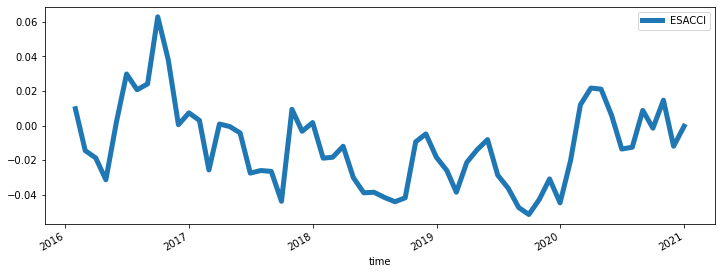

In [4]:
import matplotlib.pyplot as plt
sm_anom_list[0].plot(size=4, aspect=3,label='ESACCI', linewidth=5)
plt.legend()

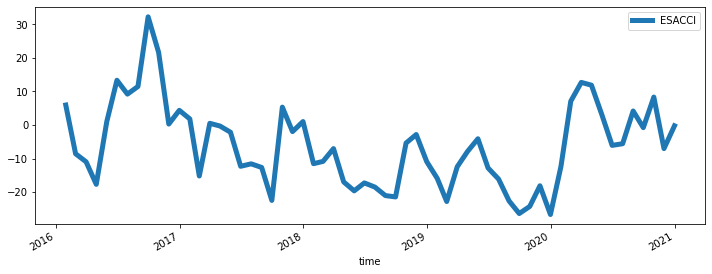

In [5]:
sm_anom_list[1].plot(size=4, aspect=3,label='ESACCI', linewidth=5)
plt.legend()

### GRACE

In [7]:
# the GRACE data
data_dir = '/g/data/w97/ad9701/GRACE/'

ds = xr.open_dataset(data_dir + 'GRCTellus.JPL.200204_202202.GLO.RL06M.MSCNv02CRI.nc')

lat_slice = slice(-44, -10)
lon_slice = slice(112, 154)
time_slice = slice('2016-01-01', '2020-12-31')

da_lwe = ds['lwe_thickness'].sel(lat = lat_slice, lon = lon_slice, time = time_slice)
da_lwe_std = ds['uncertainty'].sel(lat = lat_slice, lon = lon_slice, time = time_slice)
da_time_bounds = ds['time_bounds'].sel(time = time_slice)

# long term grace data over the region for calculations of deviations from the seasonal cycle
time_slice_lt = slice('2002-01-01', '2016-12-31')
da_lwe_lt = ds['lwe_thickness'].sel(lat = lat_slice, lon = lon_slice, time = time_slice_lt)

# calculate anomalies based on long term monthly climatology
da_lwe_monClim = da_lwe_lt.groupby('time.month').mean()
da_lwe_monAnom = da_lwe.groupby('time.month') - da_lwe_monClim

# read mask from saved file
out_file = '/g/data/w97/ad9701/drought_2017to2020/GRACE_mask_drought_focusArea.nc'
ds_mask = xr.open_dataset(out_file)
da_mask = ds_mask['mask']

da_lwe_monClim_masked = da_lwe_monClim*da_mask
da_lwe_monClim_regAvg = calc_areaAvg(da_lwe_monClim_masked)

da_lwe_monAnom_masked = da_lwe_monAnom*da_mask
da_lwe_monAnom_regAvg = calc_areaAvg(da_lwe_monAnom_masked)

da_lwe_masked = da_lwe*da_mask
da_lwe_regAvg = calc_areaAvg(da_lwe_masked)

da_lwe_std_masked = da_lwe_std*da_mask
da_lwe_std_regAvg = calc_areaAvg(da_lwe_std_masked)

da_lwe_monClim_masked = da_lwe_monClim*da_mask
da_lwe_monClim_regAvg = calc_areaAvg(da_lwe_monClim_masked)

missing_list = []

# find and insert nans for missing values
for year in [2016, 2017, 2018, 2019, 2020]:
    da_year = da_lwe_monAnom_regAvg.sel(time = str(year))

    # find the months for which the values are missing & place an empty data array there
    mon_array = np.array(range(1, 13))
    nanInd = [x not in da_year['time.month'].values for x in mon_array]
    for i in range(len(nanInd)):
        if nanInd[i]:
            da_temp = xr.DataArray(np.nan, coords={'time':datetime.datetime(year,i+1,15)})
            missing_list.append(da_temp)
            
da_missing = xr.concat(missing_list, dim='time')
da_lwe_monAnom_regAvg = da_lwe_monAnom_regAvg.drop('month')

da_lwe_monAnom_regAvg_wNan = xr.concat([da_lwe_monAnom_regAvg, da_missing], dim = 'time').sortby('time')
da_lwe_std_regAvg_wNan = xr.concat([da_lwe_std_regAvg, da_missing], dim = 'time').sortby('time')

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [29]:
# set the time co-ordinate to be the middle of the month for sm (run only once)
# for i in range(len(sm_anom_list)):
#     new_time = sm_anom_list[i].time.values - np.timedelta64(15, 'D')
#     sm_anom_list[i] = sm_anom_list[i].assign_coords({'time':new_time})
    
# for i in range(len(sm_uncert_list)):
#     new_time = sm_uncert_list[i].time.values - np.timedelta64(15, 'D')
#     sm_uncert_list[i] = sm_uncert_list[i].assign_coords({'time':new_time})

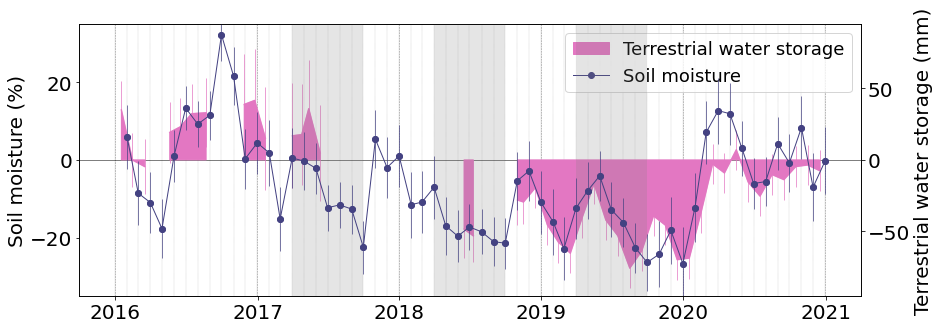

In [37]:
import pandas as pd

out_dir = 'figures/drought_2017to2020/timeseries_plots/'
col_sel = ['gray', 'orange', 'royalblue']

data_list = [sm_anom_list[1], da_lwe_monAnom_regAvg_wNan*10] #, da_E_monAnomAvg_regAvg]
data_err_list = [sm_uncert_list[1], da_lwe_std_regAvg_wNan*10] #[da_sm_uncert_regAvg, da_lwe_std_regAvg_wNan*10]
data_names = ['Soil moisture', 'Terrestrial water storage']

data_col = [sns.color_palette("icefire", 8)[2],
            sns.color_palette()[-4]]

AMJJAS_fillcol = 'grey'
AMJJAS_alpha = 0.2

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) # width, height
ax2 = ax.twinx()
axis_list = [ax, ax2]

mon_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1)#.to_numpy()#.astype(float)
year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6)#.to_numpy()

# ************ code to plot AMJJAS and DJF bars
# AMJJAS_time = pd.date_range(start = '2016-06-30', end = '2020-06-30', periods=5).to_numpy()
# AMJJAS_time = [x.astype('datetime64[D]') for x in AMJJAS_time]

# DJF_time = pd.date_range(start = '2017-01-15', end = '2020-01-15', periods=4).to_numpy()
# DJF_time = [x.astype('datetime64[D]') for x in DJF_time]

# AMJJAS_bars = []
# mon_sel = [4, 5, 6, 7, 8, 9]
# for da in data_list:
#     da_sel = da.sel(time = da.time.dt.month.isin(mon_sel))
#     da_AMJJAS_byyear = da_sel.groupby('time.year').mean()
#     AMJJAS_bars.append(da_AMJJAS_byyear.values)

# DJF_bars = []
# mon_sel = [12, 1, 2]
# for da in data_list:
#     da_seas_temp = da.resample(time="QS-DEC").mean()
#     da_seas_sel = da_seas_temp.sel(time = da_seas_temp.time.dt.month.isin([12, 1, 2]))
#     DJF_bars.append(da_seas_sel.values[1:-1])
    
# for axis, array_val,col in zip(axis_list,AMJJAS_bars,data_col):
#     axis.bar(AMJJAS_time, array_val, width=183, edgecolor='white', color=col, alpha=0.2)

# for axis,array_val,col in zip(axis_list,DJF_bars,data_col):
#     axis.bar(DJF_time, array_val, width=90, edgecolor='white', color=col, alpha=0.2)
#*************
    
for xline in mon_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)

# for axis,da, color, label, da_err in zip(axis_list,data_list, data_col, data_names, data_err_list):       
#     axis.errorbar(da.time.values, da.values, yerr=da_err.values, fmt='o', color=color, ecolor=color, elinewidth=1, capsize=0, alpha = 0.7)
#     axis.plot(da.time.values, da.values, color=color, marker="o", linewidth=1, label=label)

# A filled line for GRACE
ax2.fill_between(data_list[1].time.values, 0, data_list[1].values, color=data_col[1], label=data_names[1], zorder = 2, alpha = 1)
ax2.errorbar(data_list[1].time.values, data_list[1].values, yerr=data_err_list[1].values, color=data_col[1], ecolor=data_col[1], elinewidth=1, capsize=0, alpha = 0.7, marker=None)

# A line plot for soil moisture
ax.plot(data_list[0].time.values, data_list[0].values, marker='o', color=data_col[0], label=data_names[0], linewidth=1, zorder = 3)
ax.errorbar(data_list[0].time.values, data_list[0].values, yerr=data_err_list[0].values, fmt='o', color=data_col[0], ecolor=data_col[0], elinewidth=1, capsize=0, alpha = 0.7)

ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
    
plt.xlabel('')
ax2.set_ylabel('Terrestrial water storage (mm)')
ax.set_ylabel('Soil moisture (%)')
ax.set_ylim((-35, 35))
ax2.set_ylim((-95, 95))

#************* shading the background to indicate the AMJJAS seasons within 2017-19 instead of bars
dx = mon_breaks
# adding march in the below code as breaks are at the end of the month
fill = (mon_breaks.month.isin([3, 4, 5, 6, 7, 8, 9])) & (mon_breaks.year.isin([2017, 2018, 2019]))
ax.fill_between(dx, ax.get_ylim()[0], ax.get_ylim()[1], where=fill, fc=AMJJAS_fillcol, alpha=AMJJAS_alpha, zorder = 1)
#*************

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# legend_elements = [Line2D([0], [0], color=data_col[0], lw=1, marker="o",label=data_names[0]),
#                    Line2D([0], [0], color=data_col[1], lw=1, marker="o",label=data_names[1])]

legend_elements = [Patch(facecolor=data_col[1], edgecolor=data_col[1],label=data_names[1]),
                   Line2D([0], [0], color=data_col[0], marker='o', lw=1, label=data_names[0])]

ax2.legend(handles=legend_elements, loc=1) #, frameon = True, framealpha = 1, zorder = 3)

fig.savefig(out_dir + 'areaAvg_sm_perc_and_GRACE_anom_from_monClim.png', bbox_inches='tight', dpi=600)
fig.savefig(out_dir + 'areaAvg_sm_perc_and_GRACE_anom_from_monClim.pdf', bbox_inches='tight', format='pdf')

In [40]:
da_sm_lt_monClim

<xarray.DataArray 'sm' (month: 12, lat: 136, lon: 168)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -10.12 -10.38 -10.62 -10.88 ... -43.38 -43.62 -43.88
  * lon      (lon) float64 112.1 112.4 112.6 112.9 ... 153.1 153.4 153.6 153.9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [41]:
da_mask

<xarray.DataArray 'mask' (lat: 68, lon: 84)>
[5712 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -43.75 -43.25 -42.75 -42.25 ... -11.25 -10.75 -10.25
  * lon      (lon) float64 112.2 112.8 113.2 113.8 ... 152.2 152.8 153.2 153.8

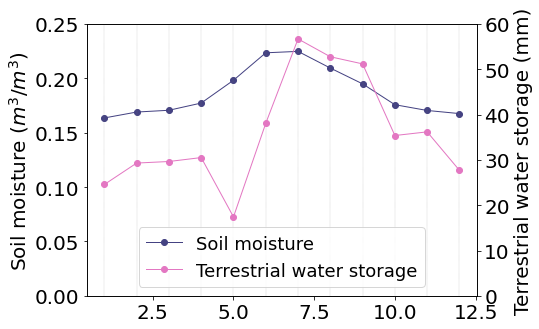

In [42]:
fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(7,5)) #width, height
ax2 = ax.twinx()

axis_list = [ax, ax2]

mask_file = '/g/data/w97/ad9701/drought_2017to2020/ESACCI_mask_drought_focusArea.nc'
ds_mask = xr.open_dataset(mask_file)
da_mask = ds_mask['mask']
data_list = [calc_areaAvg(da_sm_lt_monClim*da_mask), 
             da_lwe_monClim_regAvg*10]

for xline in range(1, 13):
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
    
for da, color, label, axis in zip(data_list, data_col, data_names, axis_list):  
    axis.plot(da.month.values, da.values, color=color, marker="o", linewidth=1, label=label)

plt.xlabel('month')
ax.set_ylabel('Soil moisture ($m^3$/$m^3$)')
ax2.set_ylabel('Terrestrial water storage (mm)')
ax2.set_ylim((0, 60))
ax.set_ylim((0, 0.25))

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=data_col[0], lw=1, marker="o",label=data_names[0]),
                   Line2D([0], [0], color=data_col[1], lw=1, marker="o",label=data_names[1])]

ax2.legend(handles=legend_elements, loc=0)

fig.savefig(out_dir + 'sm_and_GRACE_monClim_1980to2016.png', bbox_inches='tight', dpi=600)
fig.savefig(out_dir + 'sm_and_GRACE_monClim_1980to2016.pdf', bbox_inches='tight', format='pdf')

### SM anomalies

In [49]:
# calculating absolute values for csv anomaly files

data_list = [sm_anom_list[0], da_lwe_monAnom_regAvg_wNan]

AMJJAS_bars = []
mon_sel = [4, 5, 6, 7, 8, 9]
for da in data_list:
    da_sel = da.sel(time = da.time.dt.month.isin(mon_sel))
    da_AMJJAS_byyear = da_sel.groupby('time.year').mean()
    AMJJAS_bars.append(da_AMJJAS_byyear.values)

DJF_bars = []
mon_sel = [12, 1, 2]
for da in data_list:
    da_seas_temp = da.resample(time="QS-DEC").mean()
    da_seas_sel = da_seas_temp.sel(time = da_seas_temp.time.dt.month.isin([12, 1, 2]))
    DJF_bars.append(da_seas_sel.values[1:-1])

In [41]:
AMJJAS_bars

[array([  8.26699782, -10.25639701, -19.15486403, -15.0153739 ,
          1.09645649]),
 array([ 26.90267572,  19.43213539, -50.73958165, -48.56485251,
        -11.14927894])]

In [43]:
da_sm_monClim = myfuncs.calc_areaAvg(da_sm_lt_monClim*da_mask)

mon_sel = [4, 5, 6, 7, 8, 9]
sm_AMJJAS_clim = da_sm_monClim.sel(month = da_sm_monClim.month.isin(mon_sel)).mean()

mon_sel = [12, 1, 2]
sm_DJF_clim = da_sm_monClim.sel(month = da_sm_monClim.month.isin(mon_sel)).mean()

df_anom = pd.DataFrame({'season':['AMJJAS']*5,
                        'time': AMJJAS_time,
                        'anomaly (m3/m3)': np.round(AMJJAS_bars[0], 2),
                        'perc_anomaly (%)': np.round(AMJJAS_bars[0]/sm_AMJJAS_clim.values*100,1),
                       'climatology (m3/m3)': [np.round(sm_AMJJAS_clim.values, 2)]*5})
print(df_anom)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/AMJJAS_sm_anomalies.csv'
df_anom.to_csv(out_file)

df_anom = pd.DataFrame({'season':['DJF']*4,
                        'time': DJF_time,
                        'anomaly (m3/m3)': np.round(DJF_bars[0], 2),
                        'perc_anomaly (%)': np.round(DJF_bars[0]/sm_DJF_clim.values*100,1),
                       'climatology (m3/m3)': [np.round(sm_DJF_clim.values, 2)]*4})
print(df_anom)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/DJF_sm_anomalies.csv'
df_anom.to_csv(out_file)

da_anom_allDatamean = sm_anom_list[0]
da_clim_allDatamean = da_sm_monClim

anom_seasMean = da_anom_allDatamean.resample(time="QS-DEC").mean()
clim_seasMean = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'})\
.assign_coords({'time':da_anom_allDatamean.time.values}).resample(time="QS-DEC").mean()

df_anom = pd.DataFrame({'season':anom_seasMean.time.values,
                        'anomaly (m3/m3)': np.round(anom_seasMean, 2).values,
                        'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       'climatology (m3/m3)': np.round(clim_seasMean, 2).values})
print(df_anom)

out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/seas_sm_anomalies.csv'
df_anom.to_csv(out_file)

da_anom_allDatamean = sm_anom_list[0]
da_clim_allDatamean = da_sm_monClim

anom_mon = da_anom_allDatamean
clim_mon = da_clim_allDatamean.sel(month = da_anom_allDatamean['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_anom_allDatamean.time.values})

df_anom_mon = pd.DataFrame({'month':anom_mon.time.values,
                        'anomaly (m3/m3)': np.round(anom_mon, 2).values,
                        'perc_anomaly (%)': np.round(anom_mon/clim_mon*100,1).values,
                        'climatology (m3/m3)': np.round(clim_mon, 2).values})
print(df_anom_mon)
out_file_mon = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/mon_sm_anomalies.csv'
df_anom_mon.to_csv(out_file_mon)

   season       time  anomaly (m3/m3)  perc_anomaly (%)  climatology (m3/m3)
0  AMJJAS 2016-06-30             0.02               8.8                  0.2
1  AMJJAS 2017-06-30            -0.02             -10.5                  0.2
2  AMJJAS 2018-06-30            -0.04             -19.2                  0.2
3  AMJJAS 2019-06-30            -0.03             -15.2                  0.2
4  AMJJAS 2020-06-30             0.00               0.7                  0.2
  season       time  anomaly (m3/m3)  perc_anomaly (%)  climatology (m3/m3)
0    DJF 2017-01-15            -0.01              -3.1                 0.17
1    DJF 2018-01-15            -0.01              -7.1                 0.17
2    DJF 2019-01-15            -0.03             -16.6                 0.17
3    DJF 2020-01-15            -0.02             -10.6                 0.17
       season  anomaly (m3/m3)  perc_anomaly (%)  climatology (m3/m3)
0  2015-12-01            -0.00              -1.4                 0.17
1  2016-03-01     

In [ ]:
# sm anomalies by year



### GRACE

In [45]:
anom_seasMean = da_lwe_monAnom_regAvg_wNan.resample(time="QS-DEC").mean()
clim_seasMean = da_lwe_monClim_regAvg.sel(month = da_lwe_monAnom_regAvg_wNan['time.month'].values).rename({'month':'time'})\
.assign_coords({'time':da_lwe_monAnom_regAvg_wNan.time.values}).resample(time="QS-DEC").mean()

df_anom = pd.DataFrame({'season':anom_seasMean.time.values,
                        'anomaly (cm)': np.round(anom_seasMean, 5).values,
                        #'perc_anomaly (%)': np.round(anom_seasMean/clim_seasMean*100,1).values,
                       'climatology (cm)': np.round(clim_seasMean, 5).values})
print(df_anom)

out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/seas_grace_anomalies.csv'
df_anom.to_csv(out_file)

       season  anomaly (cm)  climatology (cm)
0  2015-12-01       1.74641           2.69362
1  2016-03-01       0.72958           2.58601
2  2016-06-01       2.94551           4.91844
3  2016-09-01       3.87797           4.09212
4  2016-12-01       2.83905           2.71904
5  2017-03-01       2.34506           2.58601
6  2017-06-01       0.48230           4.91844
7  2017-09-01           NaN           4.09212
8  2017-12-01           NaN           2.71904
9  2018-03-01           NaN           2.58601
10 2018-06-01      -5.07396           4.91844
11 2018-09-01      -2.87397           4.09212
12 2018-12-01      -4.08288           2.71904
13 2019-03-01      -4.07245           2.58601
14 2019-06-01      -5.68912           4.91844
15 2019-09-01      -4.94951           4.09212
16 2019-12-01      -5.85020           2.71904
17 2020-03-01      -0.16168           2.58601
18 2020-06-01      -1.70123           4.91844
19 2020-09-01      -0.73444           4.09212
20 2020-12-01      -0.74733       

In [46]:
anom_mon = da_lwe_monAnom_regAvg_wNan
clim_mon = da_lwe_monClim_regAvg.sel(month = da_lwe_monAnom_regAvg_wNan['time.month'].values).rename({'month':'time'}).assign_coords({'time':da_lwe_monAnom_regAvg_wNan.time.values})

df_anom_mon = pd.DataFrame({'month':anom_mon.time.values,
                        'anomaly (cm)': np.round(anom_mon, 5).values,
                        #'perc_anomaly (%)': np.round(anom_mon/clim_mon*100,1).values,
                        'climatology (sm)': np.round(clim_mon, 5).values})
print(df_anom_mon)
out_file_mon = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/mon_grace_anomalies.csv'
df_anom_mon.to_csv(out_file_mon)

                 month  anomaly (cm)  climatology (sm)
0  2016-01-16 12:00:00       3.49882           2.45717
1  2016-02-14 00:00:00      -0.00600           2.93007
2  2016-03-16 12:00:00      -0.46540           2.96466
3  2016-04-15 00:00:00           NaN           3.05141
4  2016-05-20 00:00:00       1.92455           1.74197
5  2016-06-16 00:00:00       2.31034           3.80749
6  2016-07-15 12:00:00       3.23161           5.67097
7  2016-08-21 12:00:00       3.29457           5.27686
8  2016-09-15 00:00:00           NaN           5.11933
9  2016-10-15 00:00:00           NaN           3.53804
10 2016-11-27 12:00:00       3.87797           3.61900
11 2016-12-24 12:00:00       4.15766           2.76986
12 2017-01-21 00:00:00       1.52043           2.45717
13 2017-02-15 00:00:00           NaN           2.93007
14 2017-03-31 12:00:00       1.68782           2.96466
15 2017-04-24 12:00:00       1.76912           3.05141
16 2017-05-12 12:00:00       3.57822           1.74197
17 2017-06

In [50]:
da_grace_monClim = da_lwe_monClim_regAvg

mon_sel = [4, 5, 6, 7, 8, 9]
grace_AMJJAS_clim = da_grace_monClim.sel(month = da_grace_monClim.month.isin(mon_sel)).mean()

mon_sel = [12, 1, 2]
grace_DJF_clim = da_grace_monClim.sel(month = da_grace_monClim.month.isin(mon_sel)).mean()

df_anom = pd.DataFrame({'season':['AMJJAS']*5,
                        'time': AMJJAS_time,
                        'anomaly (cm)': np.round(AMJJAS_bars[1], 2),
                        #'perc_anomaly (%)': np.round(AMJJAS_bars[1]/grace_AMJJAS_clim.values*100,1),
                       'climatology (cm)': [np.round(grace_AMJJAS_clim.values, 2)]*5})
print(df_anom)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/AMJJAS_grace_anomalies.csv'
df_anom.to_csv(out_file)

df_anom = pd.DataFrame({'season':['DJF']*4,
                        'time': DJF_time,
                        'anomaly (cm)': np.round(DJF_bars[1], 2),
                        #'perc_anomaly (%)': np.round(DJF_bars[1]/grace_DJF_clim.values*100,1),
                       'climatology (cm)': [np.round(grace_DJF_clim.values, 2)]*4})

print(df_anom)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/DJF_grace_anomalies.csv'
df_anom.to_csv(out_file)

   season       time  anomaly (cm)  climatology (cm)
0  AMJJAS 2016-06-30          2.69              4.11
1  AMJJAS 2017-06-30          1.94              4.11
2  AMJJAS 2018-06-30         -5.07              4.11
3  AMJJAS 2019-06-30         -4.86              4.11
4  AMJJAS 2020-06-30         -1.11              4.11
  season       time  anomaly (cm)  climatology (cm)
0    DJF 2017-01-15          2.84              2.72
1    DJF 2018-01-15           NaN              2.72
2    DJF 2019-01-15         -4.08              2.72
3    DJF 2020-01-15         -5.85              2.72
